In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.integrate import solve_ivp
from scipy.special import erfinv
import scipy.io
import pandas as pd
import time
from gekko import GEKKO
from tqdm import tqdm
import re

def MC2SSEM_population(popMC, VAR):
    """
    Creates the initial population used by SSEM, divided by species and altitude bin,
    starting from the MC population. 
    """
    # popMC = sats
    # VAR = baseline

    # Filter species based on VAR.species_types 
    active_species_indices = []
    for index, species in enumerate(VAR.species_types):
        if species:
            active_species_indices.append(index + 1)

    # Initialize lists to store classified objects
    popMC_S = []; popMC_D = []; popMC_N = []; popMC_Su = []; popMC_B = []; popMC_U = []

    # Object classification categories
    potential_payload_classes = ['Payload', 'Payload Mission Related Object', 'Other Mission Related Object', 'Rocket Mission Related Object']
    debris_classes = ['Other Debris', 'Payload Debris', 'Payload Fragmentation Debris', 'Rocket Debris', 'Rocket Fragmentation Debris']
    untracked_debris_classes = ['Untracked Debris']
    rocket_body_classes = ['Rocket Body']

    # Classify objects based on their properties
    for sat in popMC:
        alt = sat[0]['a'] * VAR.re - VAR.re  # Calculate altitude
    
        # Check if object is within altitude boundaries (% Outside boundaries TO DO: understand why this is not an || ?)
        if alt < VAR.min_altitude and alt > VAR.max_altitude:
            continue

        # Classify based on objectclass and control status 
        if any(obj_class in sat[0]['objectclass'] for obj_class in potential_payload_classes):
            if 1 in active_species_indices and 4 in active_species_indices:  # S and Su exist
                # MOCAT-4S
                if sat[0]['controlled'] == 1 and sat[0]['constel'] == 0:  # Active payload
                    if 4 in active_species_indices:
                        popMC_Su.append(sat)
                elif sat[0]['controlled'] == 1 and sat[0]['constel'] == 1: # Constellation
                    if 1 in active_species_indices:
                        popMC_S.append(sat)
                elif sat[0]['controlled'] == 0:  # Inactive payload (derelict)
                    if 2 in active_species_indices:
                        popMC_D.append(sat)
            else:
                # MOCAT-3
                if sat[0]['controlled'] == 1:
                    if 4 in active_species_indices:
                        popMC_Su.append(sat)
                else:
                    if 2 in active_species_indices:
                        popMC_D.append(sat)
        elif any(obj_class in sat[0]['objectclass'] for obj_class in debris_classes):
            if 3 in active_species_indices:
                popMC_N.append(sat)
        elif any(obj_class in sat[0]['objectclass'] for obj_class in rocket_body_classes): 
            if 5 in active_species_indices:
                popMC_B.append(sat)
        elif any(obj_class in sat[0]['objectclass'] for obj_class in untracked_debris_classes): 
            if 6 in active_species_indices:
                popMC_U.append(sat)

    # Create count lists for each species
    pop_list = [popMC_S, popMC_D, popMC_N, popMC_Su, popMC_B, popMC_U]
    count_list = np.zeros((len(pop_list), 0)).tolist()
    speciesName_list = ['Su', 'D', 'N', 'S', 'B', 'U']

    i1 = 0
    for speciesName, pop in zip(speciesName_list, pop_list):
        for species_properties in VAR.species_cells.get(speciesName, []):
            count = np.zeros((VAR.n_shells, 1))
            count_list[i1].append(count)
        i1 += 1

    # Bin objects by altitude and mass
    for species_idx, count in enumerate(count_list):
        if not count:
            continue
        for shell_idx in range(VAR.n_shells - 1):
            pop = pop_list[species_idx]
            speciesName = speciesName_list[species_idx]

            for sat in pop:
                alt = sat[0]['a'] * VAR.re - VAR.re

                if VAR.R0_km[shell_idx] <= alt < VAR.R0_km[shell_idx + 1]:
                    for species_properties in VAR.species_cells.get(speciesName, []):
                        mass_idx = 0
                        if (species_properties.mass_lb < sat[0]['mass'] <= species_properties.mass_ub):
                            count[mass_idx][shell_idx] += 1
                            break  # Object assigned to a mass bin, move to next object

    # Assemble popSSEM based on VAR.species order 
    popSSEM = np.zeros((VAR.n_shells, 0))

    for species_name, species_list in VAR.species_cells.items():
        species_idx = speciesName_list.index(species_name)
        if species_idx < len(count_list):
            popSSEM = np.hstack((popSSEM, count_list[species_idx][0]))

    return popSSEM.T.flatten().astype(int)

def randn2(*args,**kwargs):
    '''
    Calls rand and applies inverse transform sampling to the output.
    '''
    uniform = np.random.rand(*args, **kwargs)
    return np.sqrt(2) * erfinv(2 * uniform - 1)

def sort_key(symbol):
    match = re.match(r"([a-zA-Z_]+)(.*)kg(\d+)", symbol.name)  # Updated regex
    if match:
        name, middle_part, number = match.groups()
        return (name, middle_part, int(number))  # Sort by name, middle, then number
    match = re.match(r"([a-zA-Z_]+)(\d+)", symbol.name) # Original regex for other cases
    if match:
        name, number = match.groups()
        return (name, int(number))
    return (symbol.name,)  # For symbols without numbers

def create_vars_dict(ordered_difference_vars):
    vars_dict = {}
    for var in ordered_difference_vars:
        match = re.match(r"([a-zA-Z_]+.*kg)", str(var))  # Match up to "kg"
        if match:
            name = match.group(1) # Extract the name including "kg"
            if name not in vars_dict:
                vars_dict[name] = []
            vars_dict[name].append(var)
        else:
            match = re.match(r"([a-zA-Z_]+)(\d+)", str(var))
            if match:
                name, index = match.groups()
                if name not in vars_dict:
                    vars_dict[name] = []
                vars_dict[name].append(var)
            else: # Single variables
                vars_dict[str(var)] = [var] # Use variable name as key directly
                # if 'other_vars' not in vars_dict:
                #     vars_dict['other_vars'] = []
                # vars_dict['other_vars'].append(var)
    return vars_dict

class CreateOutput:
    def __init__(self, data):
        for key, value in data.items():
            setattr(self, key, value)

sel_LineWidth = 3
sel_LineWidth2 = 1.5
sel_MarkerWidth = 10
sel_LineWidthAxis = 1
sel_FontSize = 14  
# folder = '/Users/glavezzi/Library/CloudStorage/Box-Box/MIT/PROJETCS/SSEM/Draft/AAS24/figure' 

In [31]:
#==========================================================================
# Model from .json file
#==========================================================================

# filename = '../scenario-properties-test-no-run.pkl'
filename = '../scenario-properties-test-no-run-mult.pkl'
with open(filename, 'rb') as f:
    baseline = pickle.load(f)

print(f"{baseline.species_length} species: {', '.join(baseline.species_names)}")
print(f"{baseline.n_shells} shells")
print("-----------------------------------------")
# baseline.equations

# Find the difference (symbols in equations but not in all_symbolic_vars) after 
# converting the list to a set for efficient difference calculation
difference_vars = baseline.equations.free_symbols - set(baseline.all_symbolic_vars)
ordered_difference_vars = sorted(list(difference_vars), key=sort_key)

vars_dict = create_vars_dict(ordered_difference_vars)
for name, var_list in vars_dict.items():
    print(f"{name}: {var_list}")

equations_flattened = [baseline.equations[i, j] for j in range(baseline.equations.cols) for i in range(baseline.equations.rows)]

# Parameters
N_shell = baseline.n_shells
R02 = baseline.R0_km

8 species: Su, S_100kg, S_200kg, N_3kg, N_16.9kg, N_100kg, N_192kg, N_200kg
14 shells
-----------------------------------------
Pm_S_100kg: [Pm_S_100kg]
Pm_S_200kg: [Pm_S_200kg]
Pm_Su: [Pm_Su]
deltat_S_100kg: [deltat_S_100kg]
deltat_S_200kg: [deltat_S_200kg]
deltat_Su: [deltat_Su]
lambda_S_100kg: [lambda_S_100kg1, lambda_S_100kg2, lambda_S_100kg3, lambda_S_100kg4, lambda_S_100kg5, lambda_S_100kg6, lambda_S_100kg7, lambda_S_100kg8, lambda_S_100kg9, lambda_S_100kg10, lambda_S_100kg11, lambda_S_100kg12, lambda_S_100kg13, lambda_S_100kg14]
lambda_S_200kg: [lambda_S_200kg1, lambda_S_200kg2, lambda_S_200kg3, lambda_S_200kg4, lambda_S_200kg5, lambda_S_200kg6, lambda_S_200kg7, lambda_S_200kg8, lambda_S_200kg9, lambda_S_200kg10, lambda_S_200kg11, lambda_S_200kg12, lambda_S_200kg13, lambda_S_200kg14]
lambda_Su: [lambda_Su1, lambda_Su2, lambda_Su3, lambda_Su4, lambda_Su5, lambda_Su6, lambda_Su7, lambda_Su8, lambda_Su9, lambda_Su10, lambda_Su11, lambda_Su12, lambda_Su13, lambda_Su14]
u_l_S_100kg: 

In [ ]:
#==========================================================================
# Define symbolic variables based on loaded scenario
#==========================================================================
Pm_s = vars_dict['Pm_Su']
deltat_s = vars_dict['deltat_Su']
lam_s = vars_dict['lambda_']
u_var_s = vars_dict['u_l_Su']+vars_dict['u_r_N']+vars_dict['u_r_N_192.9379kg']
var_s = baseline.all_symbolic_vars

#==========================================================================
# User-selected quantities based on loaded scenario (# of species, etc.)
#==========================================================================

# Mean and standard deviation values for x0
Species_mean = np.array([100, 200, 50])
Species_std = np.array([25, 40, 10])

# Reference values for controller
ref_mult = np.array([2, 
                     0.5, 
                     0.5])
ref_dot_mult = np.array([0.5, 
                         0, 
                         -0.8]) * 0

# ADR Saturation Functions (use zero for active satellites or when no ADR is desired)
satur1 = lambda t: -(2 + np.floor(t / 10) * 5) # increase every 10 years
satur2 = lambda t: -(2 + np.floor(t / 5) * 5) # increase every 5 years

satur = [0,satur1,satur1]

# Control Settings - PD gains - Launch rate and ADR
K_p = [1 * 1,
       1 * 1,
       1 * 1]

K_d = [1 * 0.5,
       1 * 1,
       1 * 1]

#==========================================================================
# Selection
#==========================================================================
np.random.seed(25) # Seed for reproducibility

# 1: IC from predefined array ; 
# 2: IC from MC2SSEM_population ;  
# 3: generic and user selected for n species
sel_ic = 1

# 1: PD ; 2: NMPC
sel_controller = 1

# Propagation time
tf_ss = 100.0
dur = tf_ss
Ts = 1.0
tspan = np.arange(0, dur+Ts, Ts)

# ODE tolerances
rtol = 1e-2
atol = 1e-2

if sel_controller == 1:
    print('PD controller selected')
elif sel_controller == 2:
    print('NMPC controller selected')

#==========================================================================
# Control Settings - NMPC
#==========================================================================
# MPC - Prediction horizon steps
Tp = 5

# MPC - Control horizon steps
Tc = 3 # Positive integer, m, between 1 and p, inclusive, 
# where p is equal to PredictionHorizon. In this case, the controller computes 
# m free control moves occurring at times k through k+m-1, and holds the controller 
# output constant for the remaining prediction horizon steps from k+m through k+p-1. 
# Here, k is the current control interval.
# The product of Tp and Ts is the prediction time; that is,
# how far the controller looks into the future.

#==========================================================================
# Initial conditions
#==========================================================================
if sel_ic == 1:
    # Mean and standard deviation values
    S_mean = 142
    S_std = 497
    D_mean = 73
    D_std = 79
    N_mean = 280
    N_std = 354

    # Generate random values and create initial conditions
    S_rand = randn2(N_shell)
    x0_S = np.abs(np.round(S_mean + S_std * S_rand)).astype(int)
    D_rand = randn2(N_shell)
    x0_D = np.abs(np.round(D_mean + D_std * D_rand)).astype(int)
    N_rand = randn2(N_shell)
    x0_N = np.abs(np.round(N_mean + N_std * N_rand)).astype(int)

    # Combine initial conditions
    x0 = np.concatenate((x0_S, x0_N, x0_D))
    spec_names = ["Su", "N", "D"]

    # Create pandas DataFrame (equivalent to MATLAB's table)
    df = pd.DataFrame(x0.reshape((3,N_shell)).T, columns=spec_names)
    # print(df.to_string(index=False)) # Print DataFrame without index

    # Print table with shell numbers (optional)
    df_with_shell = pd.DataFrame(np.column_stack((np.arange(1, N_shell+1),x0.reshape((3,N_shell)).T)), 
                                   columns=['Shell'] + spec_names)
    print(df_with_shell.to_string(index=False)) # Print DataFrame without index

elif sel_ic == 2:
    # change order of Su with S
    baseline.species_types = [
        'Su' in baseline.species_cells and baseline.species_cells['Su'],
        'D' in baseline.species_cells and baseline.species_cells['D'],
        'N' in baseline.species_cells and baseline.species_cells['N'],
        'S' in baseline.species_cells and baseline.species_cells['S'],
        'B' in baseline.species_cells and baseline.species_cells['B'],
        'U' in baseline.species_cells and baseline.species_cells['U']
    ]
    mass_lb = 0.00141372; # lower bound of mass class for object binning (inclusive), 1 cm diameter Al sphere
    mass_ub = 100000; # upper bound of mass class for object binning (exclusive, except for top mass bin, which is inclusive)
    for species_name, species_list in baseline.species_cells.items():
        for species_properties in species_list:
            species_properties.mass_lb = mass_lb
            species_properties.mass_ub = mass_ub
    init_mat = scipy.io.loadmat('initialized.mat')
    sats = init_mat['sats']
    x0 = MC2SSEM_population(sats, baseline)
    spec_names = ["Su", "N", "D"]

    # Create pandas DataFrame (equivalent to MATLAB's table)
    df = pd.DataFrame(x0.reshape((3,N_shell)).T, columns=spec_names)
    # print(df.to_string(index=False)) # Print DataFrame without index
    x0_S = df['Su'].values
    x0_D = df['D'].values
    x0_N = df['N'].values

    # Print table with shell numbers (optional)
    df_with_shell = pd.DataFrame(np.column_stack((np.arange(1, N_shell+1),x0.reshape((3,N_shell)).T)), 
                                   columns=['Shell'] + spec_names)
    print(df_with_shell.to_string(index=False)) # Print DataFrame without index

elif sel_ic == 3:
    x0 = []
    for i1 in range(baseline.species_length):
        # Generate random values and create initial conditions
        Species_rand = randn2(N_shell)
        # Combine initial conditions
        x0 = np.concatenate((x0, np.abs(np.round(Species_mean[i1] + Species_std[i1] * Species_rand))))

    x0 = x0.astype(int)
    # Create pandas DataFrame (equivalent to MATLAB's table)
    df = pd.DataFrame(x0.reshape((3,N_shell)).T, columns=baseline.species_names)
    # print(df.to_string(index=False)) # Print DataFrame without index

    # Print table with shell numbers (optional)
    df_with_shell = pd.DataFrame(np.column_stack((np.arange(1, N_shell+1),x0.reshape((3,N_shell)).T)), 
                                    columns=['Shell'] + baseline.species_names)
    print(df_with_shell.to_string(index=False)) # Print DataFrame without index

#==========================================================================
# Reference values
#==========================================================================

if sel_ic == 3:
    ref = []
    ref_dot = []
    for i1 in range(baseline.species_length):
        start_idx = i1 * baseline.n_shells
        end_idx = start_idx + baseline.n_shells
        ref = np.concatenate((ref, x0[start_idx:end_idx] * ref_mult[i1]))
        ref_dot = np.concatenate((ref_dot, np.ones(baseline.n_shells) * ref_dot_mult[i1]))
else:
    ref_S = x0_S * ref_mult[0] * 1
    ref_D = x0_D * ref_mult[1] * 1
    ref_N = x0_N * ref_mult[2] * 1
    ref_S_dot = np.ones(N_shell) * ref_dot_mult[0] * 0
    ref_D_dot = np.ones(N_shell) * ref_dot_mult[1] * 0
    ref_N_dot = np.ones(N_shell) * ref_dot_mult[2] * 0

    ref = np.concatenate([ref_S, ref_N, ref_D])
    ref_dot = np.concatenate([ref_S_dot, ref_N_dot, ref_D_dot])

#==========================================================================
# Launch rate (lambda) selection
#==========================================================================
# Lambda functions for launch rate selection
def x0_lam_f1(t):
    return np.zeros(N_shell)

def x0_lam_f2(t):
    return 0.5 * x0_S

def x0_lam_f3(t):
    return np.random.rand(N_shell) * x0_S

# Define parameters for x0_lam_f4
lam_mean = 150
lam_std = 30

def x0_lam_f4(t):
    return np.round(lam_mean + lam_std * randn2(N_shell)).astype(int)

# Define phase shifts for x0_lam_f5
phase_shifts = 2 * np.pi / np.random.randint(1, N_shell + 1, size=N_shell)

def x0_lam_f5(t):
    return 0.5 * x0_S * (np.cos((2*np.pi/10)*t + phase_shifts) / 6 + 1)

# Initialize arrays 
x0_lam_no_noise = np.zeros((N_shell, len(tspan)))
x0_lam = np.zeros((N_shell, len(tspan)))

# Evaluate lambda functions for each time step
for i1 in range(len(tspan)):
    x0_lam_no_noise[:, i1] = x0_lam_f1(tspan[i1])
    x0_lam[:, i1] = x0_lam_f1(tspan[i1]) 


# # Figure: lambda with and without noise
# plt.figure(facecolor='white')
# plt.xlabel('Time (years)')
# plt.ylabel('$\lambda$')
# plt.grid(True)

# plt.plot(sum(x0_lam), linewidth=sel_LineWidth, label='w/ noise')
# plt.plot(sum(x0_lam_no_noise), '--', linewidth=sel_LineWidth, label='w/o noise')

# plt.legend(loc='best')
# plt.show()

#==========================================================================
# PMD selection
#==========================================================================

# 1. Constant PMD
PMD1 = 0.9 * np.ones_like(tspan)

# 2. Increasing PMD
n = len(tspan)
lower_bound = 0.7
upper_bound = 0.999
base_sequence = np.linspace(0, 1, n)
PMD2 = lower_bound + (base_sequence * (upper_bound - lower_bound))

# 3. Increasing PMD with Randomness
base_sequence = np.linspace(0, 1, n)
random_variations = (np.random.rand(n) - 0.5) * 0.5 
final_sequence = base_sequence + random_variations
final_sequence = np.clip(final_sequence, 0, upper_bound) # Keep values within [0, upper_bound]
PMD3 = lower_bound + (final_sequence * (upper_bound - lower_bound))

PMD_no_noise = PMD1
PMD = PMD1

# # Figure: PMD vs Time
# plt.figure(facecolor='white')  # Set figure size
# plt.title('PMD vs Time')
# plt.xlabel('Time (years)')
# plt.ylabel('P_M (%)')
# plt.grid(True)

# plt.plot(tspan, PMD1 * 100, linewidth=sel_LineWidth, color=colors[1], label="P$_M^{\#1}$")  # Python uses 0-based indexing for colors
# plt.plot(tspan, PMD2 * 100, linewidth=sel_LineWidth, color=colors[2], label="P$_M^{\#2}$")
# plt.plot(tspan, PMD3 * 100, linewidth=sel_LineWidth, color=colors[3], label="P$_M^{\#3}$")

# plt.xticks(fontsize=sel_FontSize)
# plt.yticks(fontsize=sel_FontSize)
# plt.gca().tick_params(width=sel_LineWidthAxis)
# plt.legend(loc='best')

# plt.savefig('pmd_opt.pdf', format='pdf', dpi=300)  # Save as PDF with 300 DPI

# # Figure: PMD with and without noise
# plt.figure(facecolor='white')
# plt.xlabel('Time (years)')
# plt.ylabel('PMD')
# plt.grid(True)

# plt.plot(PMD, linewidth=sel_LineWidth, label='w noise')
# plt.plot(PMD_no_noise, '--', linewidth=sel_LineWidth, label='w/o noise')

# # plt.legend(loc='best')
# plt.show()

#==========================================================================
# Additional parameters selection
#==========================================================================

# Orbital lifetime [years]
deltat1 = 8 * np.ones_like(tspan)

deltat_no_noise = deltat1
deltat = deltat1

# Alpha_no_noise = 0.15 * np.ones_like(tspan) 
# alpha_active_no_noise = 0.015 * np.ones_like(tspan) 
# Delta_no_noise = 5 * np.ones_like(tspan)

# Alpha = Alpha_no_noise + 0 * Alpha_no_noise / 3.5 * np.random.randn(*tspan.shape)
# alpha_active = alpha_active_no_noise + 0 * alpha_active_no_noise / 3.5 * np.random.randn(*tspan.shape)
# Delta = Delta_no_noise + 0 * Delta_no_noise / 3 * np.random.randn(*tspan.shape)


PD controller selected
 Shell  Su   N   D
     1 702 209   5
     2 245 224  77
     3 149  75  37
     4 302 734 114
     5  30 435  46
     6 449 241 150
     7 381  84  69
     8  64 303  76
     9 212 333  49
    10  27 514 295
    11  19 615  76
    12 460 609  85
    13  76 224  71
    14 249 412 119


In [14]:
#==========================================================================
# Define propagation function
#==========================================================================

func = sp.lambdify((var_s, u_var_s, np.concatenate((lam_s, Pm_s, deltat_s)).tolist()), equations_flattened, 'numpy')

def ode_func(t, x, func, u_var, mdd):
    return np.array(func(x, u_var, mdd)).flatten()

#==========================================================================
# Propagation with control
#==========================================================================

x00 = x0

if sel_controller == 1:
#==========================================================================
# PD
#==========================================================================
    # Initialize arrays
    x_prop_all = np.zeros((len(tspan), baseline.species_length*N_shell))
    u_all = np.zeros((len(tspan), baseline.species_length*N_shell))
    x_prop_all[0, :] = x00

    # Start timing
    start_time = time.time()

    for i1 in range(len(tspan) - 1):
        md_no_noise = np.concatenate((x0_lam_no_noise[:, i1], [PMD_no_noise[i1], deltat_no_noise[i1]]))
        md = np.concatenate((x0_lam[:, i1], [PMD[i1], deltat[i1]]))

        sol = solve_ivp(ode_func, 
                        (tspan[i1], tspan[i1+1]), 
                        x00, 
                        method=baseline.integrator,
                        args=(func,np.zeros(len(u_var_s)),md_no_noise),
                        rtol=rtol, atol=atol)
        x_prop = sol.y[:, -1]
        
        sol_actual = solve_ivp(ode_func, 
                        (tspan[i1], tspan[i1+1]), 
                        x00, 
                        method=baseline.integrator,
                        args=(func,np.zeros(len(u_var_s)),md),
                        rtol=rtol, atol=atol)
        x_prop_actual = sol_actual.y[:, -1]

        x_dot_prop = np.array(func(x_prop, np.zeros(len(u_var_s)), md_no_noise)).flatten()

        u_list = []
        for i2 in range(baseline.species_length):
            start_idx = i2 * baseline.n_shells
            end_idx = start_idx + baseline.n_shells
            if baseline.species_names[i2].startswith('S'): # Launch rate controllers
                u_eval = np.maximum(K_p[i2] * (ref[start_idx:end_idx] - x_prop[start_idx:end_idx]) + K_d[i2] * (ref_dot[start_idx:end_idx] - x_dot_prop[start_idx:end_idx]), 0)
                u_list = np.concatenate([u_list, u_eval])
            else: # ADR controllers
                u_eval = np.minimum(K_p[i2] * (ref[start_idx:end_idx] - x_prop[start_idx:end_idx]) + K_d[i2] * (ref_dot[start_idx:end_idx] - x_dot_prop[start_idx:end_idx]), 0)
                if np.sum(u_eval) < satur[i2](tspan[i1+1]):
                    u_eval = u_eval * (satur[i2](tspan[i1+1]) / np.sum(u_eval))
                u_list = np.concatenate([u_list, u_eval])

        # x00a = x_prop_actual + u_list
        sol_actual_last = solve_ivp(ode_func, 
                        (tspan[i1], tspan[i1+1]), 
                        x00, 
                        method=baseline.integrator,
                        args=(func, u_list, md),
                        rtol=rtol, atol=atol)
        x_prop_actual_last = sol_actual_last.y[:, -1]
        x00b = x_prop_actual_last # x00b
        # print(np.sum(x00a)-np.sum(x00b))

        x00 = x00b
        x_prop_all[i1+1, :] = x00
        u_all[i1+1, :] = u_list 
        
    # End timing
    propagation_time = time.time() - start_time 
    mvHistory = u_all.T
    xHistory = x_prop_all.T

elif sel_controller == 2:
#==========================================================================
# NMPC
#==========================================================================

    def myCostFunction(x, u, r):
        """
        Custom cost function for nonlinear MPC.
        """
        J = np.sum((x - r)**2)
        # J = np.sum(np.abs(x - r))
        return J 

    nx = len(var_s)
    nu = len(u_var_s)
    nd = len(lam_s) + len(Pm_s) + len(deltat_s)

    # Create GEKKO model (similar to nlmpc in MATLAB)
    m = GEKKO(remote=False) 

    # Input variables (MVs)
    u = m.Array(m.MV, nu) 
    for i in range(nu):
        u[i].STATUS = 1
        u[i].VALUE = 0

    for i1 in range(baseline.species_length):
        start_idx = i1 * baseline.n_shells
        end_idx = start_idx + baseline.n_shells
        if baseline.species_names[i1].startswith('S'): 
            for i in range(start_idx,end_idx): 
                u[i].LOWER = 0 # Launch rate (lambda) minimum 
        else: 
            for i in range(start_idx,end_idx): 
                u[i].UPPER = 0 # ADR maximum 

    # State variables (x)
    x = m.Array(m.Var, nx)

    # Measured disturbances (MDs)
    d = m.Array(m.Param, nd) 

    # Set initial conditions for state variables
    for i in range(nx):
        x[i].VALUE = x00[i]

    # Define the model equations
    m.Equations([x[i].dt() == func(x, u, d)[i] for i in range(nx)])

    # Set objective function
    # m.Obj(myCostFunction(x, u, ref))
    x_cost = m.Intermediate(m.sum( (x - ref)**2 ))
    m.Minimize(x_cost)

    # Set inequality constraints
    satur_eval_list = []
    for i1 in range(baseline.species_length):
        start_idx = i1 * baseline.n_shells
        end_idx = start_idx + baseline.n_shells
        if not baseline.species_names[i1].startswith('S'):
            satur_eval = m.Param(value=satur[i1](tspan[0]))  
            satur_eval_list.append(satur_eval)
            m.Equations([-np.sum(u[start_idx:end_idx]) + satur_eval <= 0])
        else:
            satur_eval_list.append(0)
    
    # Solver options
    m.options.IMODE = 6  # MPC mode
    m.options.CV_TYPE = 2 # squared error
    m.options.NODES = 2  # Collocation points (WARNING: 3 was not working)
    m.options.SOLVER = 3  # 1: APOPT, 2: BPOPT, 3: IPOPT.
    # IPOPT is generally the best for problems with large numbers of 
    # degrees of freedom or when starting without a good initial guess. 
    # BPOPT has been found to be the best for systems biology applications. 
    # APOPT is generally the best when warm-starting from a prior solution 
    # or when the number of degrees of freedom (Number of Variables - Number
    # of Equations) is less than 2000. APOPT is also the only solver that 
    # handles Mixed Integer problems. Use option 0 to compare all available solvers.

    # Set sampling time, prediction horizon, and control horizon
    m.options.TIME_SHIFT = 1
    # m.options.OTOL = 1e-2
    # m.options.RTOL = 1e-2
    
    print(f"\nSampling Time: {m.options.TIME_SHIFT*Ts:.2f} y")
    print(f"\nPrediction Horizon steps: {Tp}")
    # print(f"\nControl Horizon steps: {Tc}")
    print(f"\nPrediction time: {Ts*Tp:.2f} y")
    print(f"\nSimulation time: {dur:.2f} y\n\n")
        
    # Simulation loop
    xHistory = x00
    xeval = x00
    mvHistory = np.zeros(x00.shape)
    start_time = time.time()
    for ct in tqdm( range( len(tspan) - 1 ) ):
        m.time = np.linspace(tspan[ct], tspan[ct+1], 2)
        # m.time = np.linspace(ct, (Tp*Ts) + ct, Tp+1)

        for i1 in range(baseline.species_length):
            if not baseline.species_names[i1].startswith('S'): 
                satur_eval_list[i1].value = satur[i1](m.time)

        md_no_noise = np.concatenate((x0_lam_no_noise[:, ct], [PMD_no_noise[ct], deltat_no_noise[ct]]))
        md = np.concatenate((x0_lam[:, i1], [PMD[ct], deltat[ct]]))

        # Update measured disturbances         
        for i in range(nd):
            d[i].VALUE = md_no_noise[i]

        # Solve the optimization problem
        m.solve(disp=False)

        # Get optimal control moves
        ueval = []
        for i in range(nu):
            u[i].VALUE = u[i][1]
            ueval = np.append(ueval, u[i].VALUE)

        # Update initial conditions for next time step
        sol = solve_ivp(ode_func, 
                        (tspan[ct], tspan[ct+1]), 
                        xeval, 
                        method=baseline.integrator,
                        args=(func,ueval,md),
                        rtol=rtol, atol=atol)
        xeval = sol.y[:, -1]
        
        for i in range(nx):
            x[i].VALUE = xeval[i]

        # Store history
        xHistory = np.column_stack([xHistory,xeval])
        mvHistory = np.column_stack([mvHistory,ueval])

    propagation_time = time.time() - start_time

print(f"Propagation time: {propagation_time:.4f} seconds")
t_prop = tspan

# x_dot_prop = np.array(func(x_prop.T, np.zeros(len(u_var_s)), md)).flatten()
# x_dot_prop = x_dot_prop.reshape((len(tspan), len(var_s)))

#==========================================================================
# Propagation without control
#==========================================================================

x00 = x0
x_prop_nc = np.zeros((len(tspan), baseline.species_length*N_shell))
x_prop_nc[0, :] = x00

if np.sum(x0_lam) == 0: # Use the lambda values from the control solution
    x0_lam = mvHistory[:N_shell]     

for i1 in range(len(tspan) - 1):
    if np.sum(x0_lam) != 0:
        md = np.concatenate((x0_lam[:, i1+1], [PMD[i1], deltat[i1]])) 
    else:
        md = np.concatenate((x0_lam[:, i1], [PMD[i1], deltat[i1]])) 
    sol = solve_ivp(ode_func, 
                    (tspan[i1], tspan[i1+1]), 
                    x00, 
                    method=baseline.integrator,
                    args=(func,np.zeros(len(u_var_s)),md),
                    # args=(func, np.concatenate([lam_prop[i1+1]*1, adr_n_prop[i1]*0, adr_d_prop[i1]*0], axis=0), md),
                    rtol=rtol, atol=atol)
    x_prop_nc[i1+1, :] = sol.y[:, -1]
    x00 = sol.y[:, -1]
t_prop_nc = tspan

Propagation time: 0.6581 seconds


/var/folders/8r/pmy63vtd1lbbfd8ptmtgcr4w0000gn/T/ipykernel_51648/3161262564.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_base_species))


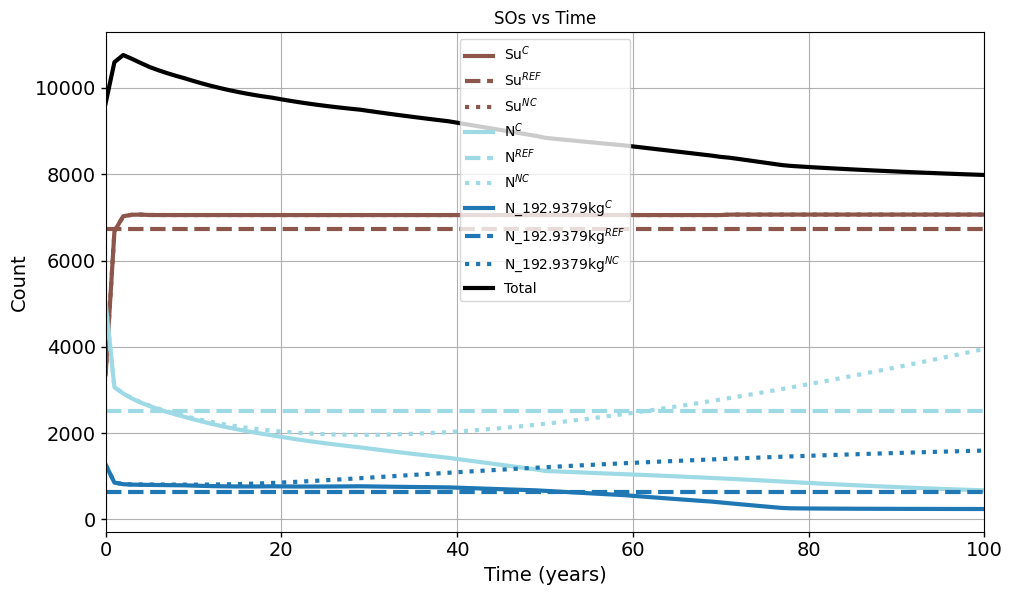

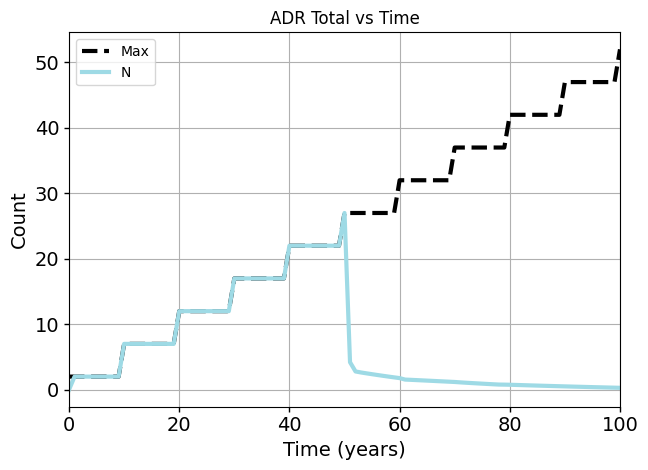

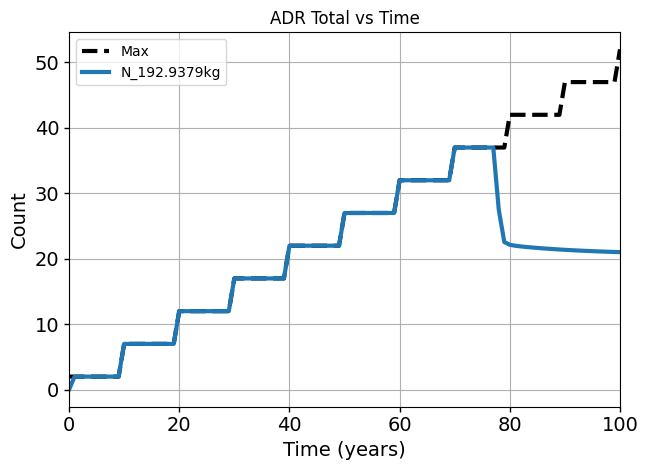

In [15]:
#==========================================================================
# Variable definition for plots
#==========================================================================
# size = (42,101)
baseline.output = {}
baseline.output['t'] = t_prop
baseline.output['y'] = xHistory
baseline.output['y_nc'] = x_prop_nc.T
baseline.output['y_u'] = mvHistory
baseline.output['y_ref'] = np.concatenate([np.tile(ref_S, (len(t_prop), 1)), np.tile(ref_N, (len(t_prop), 1)), np.tile(ref_D, (len(t_prop), 1))], axis=1).T
baseline.output['ydot_ref'] = np.concatenate([np.tile(ref_S_dot, (len(t_prop), 1)), np.tile(ref_N_dot, (len(t_prop), 1)), np.tile(ref_D_dot, (len(t_prop), 1))], axis=1).T
# size = (101,)
baseline.output['satur'] = satur

output = CreateOutput(baseline.output)
n_species = baseline.species_length
num_shells = baseline.n_shells
species_names = baseline.species_names
orbital_shell_labels = baseline.R0_km[:num_shells]
markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', '*', 'h']

base_species_names = baseline.species_names
unique_base_species = list(set(base_species_names))
color_map = plt.cm.get_cmap('tab20', len(unique_base_species))

#==========================================================================
# Plots
#==========================================================================

# Total objects over time for each species and total
plt.figure(facecolor='white',figsize=(10, 6))
plt.grid(True)
total_objects_all_species = np.zeros_like(output.t)
for species_index in range(n_species):
    color = color_map(unique_base_species.index(base_species_names[species_index]))
    # marker = markers[species_index % len(markers)]
    start_idx = species_index * num_shells
    end_idx = start_idx + num_shells
    total_objects_per_species = np.sum(output.y[start_idx:end_idx, :], axis=0)
    plt.plot(output.t, total_objects_per_species, linewidth=sel_LineWidth, label=species_names[species_index]+"$^{C}$", color=color, linestyle='-') #, marker=marker, markersize=sel_MarkerWidth)
    plt.plot(output.t, np.sum(output.y_ref[start_idx:end_idx, :], axis=0), linewidth=sel_LineWidth, label=species_names[species_index]+"$^{REF}$", color=color, linestyle='--')
    plt.plot(output.t, np.sum(output.y_nc[start_idx:end_idx, :], axis=0), linewidth=sel_LineWidth, label=species_names[species_index]+"$^{NC}$", color=color, linestyle=':')
    total_objects_all_species += total_objects_per_species
plt.plot(output.t, total_objects_all_species, label='Total', color='k', linewidth=sel_LineWidth, linestyle='-')
plt.xlabel('Time (years)', fontsize=sel_FontSize)
plt.ylabel('Count', fontsize=sel_FontSize)
plt.title('SOs vs Time')
plt.xlim(0, max(output.t))
plt.legend(loc="best")
plt.tight_layout()
plt.xticks(fontsize=sel_FontSize)
plt.yticks(fontsize=sel_FontSize)
plt.gca().tick_params(width=sel_LineWidthAxis)
plt.show()


# ADR Total vs Time
for species_index in range(n_species):
    if not base_species_names[species_index].startswith('S'):
        plt.figure(facecolor='white')
        plt.grid(True)
        color = color_map(unique_base_species.index(base_species_names[species_index]))
        start_idx = species_index * num_shells
        end_idx = start_idx + num_shells
        plt.plot(output.t, -output.satur[species_index](output.t), linewidth=sel_LineWidth, label='Max', color='k', linestyle='--') 
        plt.plot(output.t, -np.sum(output.y_u[start_idx:end_idx, :], axis=0), linewidth=sel_LineWidth, label=species_names[species_index], color=color, linestyle='-')
        plt.title('ADR Total vs Time')
        plt.xlabel('Time (years)', fontsize=sel_FontSize)
        plt.ylabel('Count', fontsize=sel_FontSize)
        plt.xticks(fontsize=sel_FontSize)
        plt.yticks(fontsize=sel_FontSize)
        plt.tight_layout()
        plt.xlim(0, max(output.t))
        plt.gca().tick_params(width=sel_LineWidthAxis)
        plt.legend(loc='best')
        plt.show()
